In [8]:
%matplotlib notebook
import cv2, time
import numpy as np
import argparse, pprint
import matplotlib

from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.transforms import Bbox
import matplotlib.gridspec as gridspec

from Tkinter import Tk
import tkFileDialog as filedialog

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual

pp = pprint.PrettyPrinter(indent=4)

In [9]:
def uvMapping(_img, get_overlay=True,verbose=False):
    overlay = None
    h,w = _img.shape
    histRange = (0,256)
    histSz = np.max(_img) + 1
    if(verbose): print("[UV Mapping] Input Image Size: (%d, %d)" % (h,w))

    umap = np.zeros((histSz,w,1), dtype=np.uint8)
    vmap = np.zeros((h,histSz,1), dtype=np.uint8)

    for i in range(0,h):
        vscan = _img[i,:]
        vrow = cv2.calcHist([vscan],[0],None,[histSz],histRange)
        if(verbose): print("\t[V Mapping] Scan [%d] (%s) ---- Scan Histogram (%s)" % (i,', '.join(map(str, vscan.shape)), ', '.join(map(str, vrow.shape))))
        vmap[i,:] = vrow

    for i in range(0,w):
        uscan = _img[:,i]
        urow = cv2.calcHist([uscan],[0],None,[histSz],histRange)
        if(verbose): print("\t[U Mapping] Scan[%d] (%s) ---- Scan Histogram (%s)" % (i,', '.join(map(str, uscan.shape)), ', '.join(map(str, urow.shape))))
        umap[:,i] = urow

    umap = np.reshape(umap,(histSz,w))
    vmap = np.reshape(vmap,(h,histSz))

    if(get_overlay):
        blank = np.ones((umap.shape[0],vmap.shape[1]),np.uint8)*255
        pt1 = np.concatenate((_img, vmap), axis=1)
        pt2 = np.concatenate((umap,blank),axis=1)
        overlay = np.concatenate((pt1,pt2),axis=0)
        overlay = cv2.cvtColor(overlay,cv2.COLOR_GRAY2BGR)

    if(verbose):
        print("\t[UV Mapping] U Map = (%s) ----- V Map = (%s)" % (', '.join(map(str, umap.shape)),', '.join(map(str, vmap.shape)) ))
    return umap,vmap,overlay

<IPython.core.display.Javascript object>


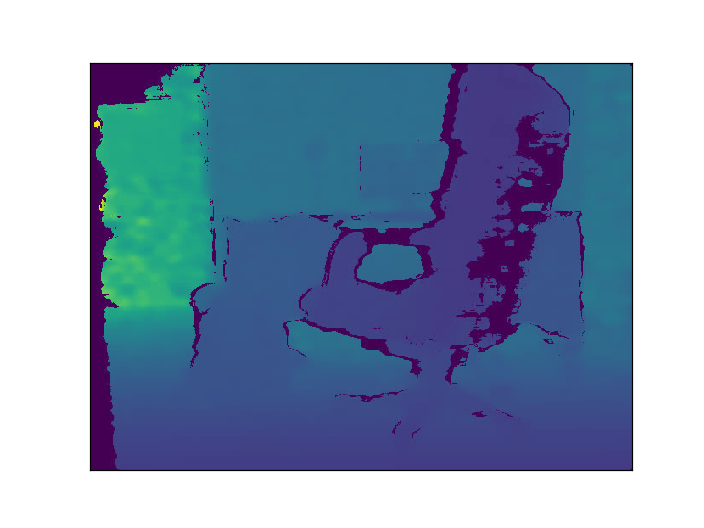

<IPython.core.display.Javascript object>


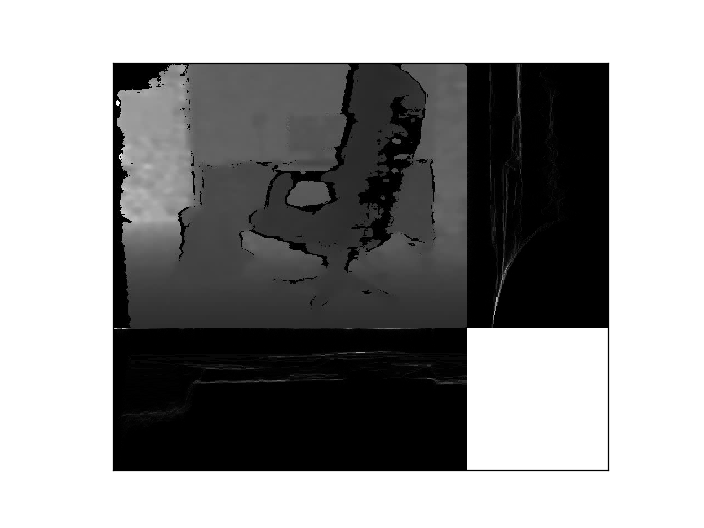

In [3]:
rootPath = "scripts/python/vision_playground/"
# imgname = "frames/frame_509.jpg"
imgname = "test_disparity.png"
img = cv2.imread(rootPath+imgname,cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(img)
plt.yticks([])
plt.xticks([])
plt.show()

umap,vmap, overlay = uvMapping(img)

plt.figure()
plt.imshow(overlay)
plt.yticks([])
plt.xticks([])
plt.show()



In [31]:
def line_finder(_img,method,e1,e2,ang,rho,minLineLength,maxLineGap,houghThresh,greyThresh,show_helpers):
    print(
    """
    Inputs:
    ------
     
    \t* Kernel Size       : (%d, %d)
    \t* Rho, Angle (deg)  :  %d, %d
    \t* Min Line Length   :  %d
    \t* Max Line Gap      :  %d
    \t* Grey Thresholding :  %d
    \t* Hough Threshold   :  %d
    """ % (
        e1,e2,rho,ang,minLineLength,maxLineGap,greyThresh,houghThresh
    ))
    helper_imgs = []
    img = cv2.imread(_img,cv2.IMREAD_GRAYSCALE)
#     plt.figure(); plt.imshow(img)
#     plt.yticks([]); plt.xticks([]); plt.show()

    umap,vmap, overlay = uvMapping(img)

    

    tmp2 = np.copy(umap)
    tmp = cv2.cvtColor(tmp2,cv2.COLOR_GRAY2BGR)

#     tmp2 = cv2.cvtColor(tmp2,cv2.COLOR_BGR2GRAY)
    # tmp = cv2.cvtColor(tmp2,cv2.COLOR_BGR2GRAY)
    # tmp = cv2.resize(img, (640,480))

    # get current positions of four trackbars
    n,m,_ = tmp.shape
    print(tmp.shape)
    filtered = np.zeros((n,m,3))

    ret, grey = cv2.threshold(tmp2,greyThresh,255,cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((e1,e2),np.uint8)
    closing = cv2.morphologyEx(grey,cv2.MORPH_CLOSE,kernel, iterations = 2)

    ret, helper = cv2.threshold(grey,greyThresh,255,cv2.THRESH_BINARY_INV)
    ret, helper2 = cv2.threshold(closing,greyThresh,255,cv2.THRESH_BINARY_INV)
    hlines = cv2.Canny(helper2,50,150,apertureSize = 3)
    helper_imgs.append(tmp); helper_imgs.append(grey)   
    helper_imgs.append(closing); helper_imgs.append(helper); helper_imgs.append(helper2)
    helper_imgs.append(hlines)
    
    
    ang = ang * np.pi/180
    try:
        if(method==0):
            lines = cv2.HoughLines(hlines,rho,ang,houghThresh)
            count = 0
            for rho,theta in lines[0]:
                count+=1
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                cv2.line(tmp,(x1,y1),(x2,y2),(0,0,255),2)
                cv2.line(filtered,(x1,y1),(x2,y2),(255,255,255),2)
        else:
            lines = cv2.HoughLinesP(hlines,rho,ang,houghThresh,minLineLength,maxLineGap)
            for x in range(0, len(lines)):
                for x1,y1,x2,y2 in lines[x]:
                    cv2.line(tmp,(x1,y1),(x2,y2),(0,255,0),2)
                    cv2.line(filtered,(x1,y1),(x2,y2),(255,255,255),2)
    except:
        pass
    
    fig, axs = None, None
    
    if(show_helpers):
        fig, axs = plt.subplots(3,3); idx = 0
        for ax in axs.flatten():
            try:
                ax.imshow(helper_imgs[idx],cmap='Greys')
                ax.set_xticklabels('')
                ax.set_yticklabels('')
                ax.axis('equal')
                idx+=1
            except:
                print("Hough Transform Error")
                pass
        
#     cv2.imshow('lines',tmp)
#     cv2.imshow('filtered',filtered)
#     plt.figure(); plt.imshow(overlay)
#     plt.yticks([]); plt.xticks([]); plt.show()
    
p=interactive(line_finder,
    _img="scripts/python/vision_playground/test_disparity.png",
    method={'Standard Hough Transform':0,'Probabilistic Hough Transform':1},
    e1=(1,255,1), e2=(1,255,1),
    ang=(0,360,1), rho=(1,1000,1),
    minLineLength=(0,255,1), maxLineGap=(0,255,1),
    houghThresh=(0,255,1), greyThresh=(0,255,1),
    show_helpers=True
)
display(p)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KFRleHQodmFsdWU9dSdzY3JpcHRzL3B5dGhvbi92aXNpb25fcGxheWdyb3VuZC90ZXN0X2Rpc3Bhcml0eS5wbmcnLCBkZXNjcmlwdGlvbj11J19pbWcnKSzigKY=
